<a href="https://colab.research.google.com/github/Gricay-vasily/project_9_DCGAN/blob/main/Learning_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Навчання Deep Convolutional Generative Adversarial Network (DCGAN) на завантажених даних Cifar

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

2024-07-25 06:09:59.211462: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-25 06:09:59.243306: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-25 06:09:59.243844: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-25 06:09:59.840278: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Завантаження і підготовка Дата-сетів

### Зчитування мета-даних

Посилання на дані

In [2]:
URL_DIR = "https://www.cs.toronto.edu/~kriz/"
cifar=10

if cifar == 10:
    FILE_NAME_CIFAR = "cifar-10-python.tar.gz"
if cifar ==100:
    FILE_NAME_CIFAR = "cifar-100-python.tar.gz"

Завантажимо дані

In [3]:
def load_and_unzip_cifar(url:str, file_name:str):
  '''Завантаження і розпакування файлу-архіву, якщо ще цього не зроблено'''
  from pathlib import Path
  # Завантаження даних
  full_url_to_load = url + file_name
  print(full_url_to_load)
  if Path(file_name).exists() and Path(file_name).is_file():
    print(f"Файл {file_name} вже є. Немає потреби його завантажувати!")
  else:
    print(f"Заватажуємо файл {file_name} ")
    !wget $full_url_to_load
  # Розпакування даних
  # Створення робочої папки через stem i split - відсікання суфіксів
  work_dir = Path(str((Path() / Path(file_name).stem)).split(".")[0])
  # print(work_dir)
  if work_dir.exists() and work_dir.is_dir():
    print(f"Директорія {work_dir} вже існує, перезаписуємо файли")
    # Перезаписуємо, бо є файли, які не дають видалити папку
    !tar -xzvf $file_name
  else:
    print(f"Розпакуємо файл {file_name}")
    !tar -xzvf $file_name

load_and_unzip_cifar(URL_DIR, FILE_NAME_CIFAR)

https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Заватажуємо файл cifar-10-python.tar.gz 
--2024-07-25 06:10:00--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Визначення імені www.cs.toronto.edu (www.cs.toronto.edu)… 128.100.3.30
Встановлення з'єднання з www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... з’єднано.
HTTP-запит надіслано, очікуємо на відповідь… 200 OK
Довжина: 170498071 (163M) [application/x-gzip]
Зберігаємо до «cifar-10-python.tar.gz»

cifar-10-python.tar 100%[===================>] 162,60M  11,5MB/s    за 15s     

2024-07-25 06:10:16 (10,9 MB/s) - «cifar-10-python.tar.gz» збережено [170498071/170498071]

Розпакуємо файл cifar-10-python.tar.gz
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [4]:
def unpickle(file):
  '''Десеріалізація даних з pickle-файлу'''
  import pickle
  with open(file, 'rb') as fo:
      dict = pickle.load(fo, encoding='bytes')
  return dict

In [5]:
if cifar == 10:
  metadata_path = './cifar-10-batches-py/batches.meta' # шлях до даних"
  metadata = unpickle(metadata_path)
  superclass_dict = dict(list(enumerate(metadata[b'label_names'])))
if cifar ==100:
  metadata_path = './cifar-100-python/meta' # шлях до даних
  metadata = unpickle(metadata_path)
  superclass_dict = dict(list(enumerate(metadata[b'coarse_label_names'])))

### Завантаження тренувальної та тестувальної вибірок (використовуючи суперкласи):

In [6]:
if cifar == 100:
  data_pre_path = './cifar-100-python/' # шлях до даних
  # шляхи до файлів
  data_train_path = data_pre_path + 'train'
  data_test_path = data_pre_path + 'test'
  # Зчитуємо словники
  data_train_dict = unpickle(data_train_path)
  data_test_dict = unpickle(data_test_path)
  # Отримуємо дані (вибираємо coarse_labels щоб отримати всі 100 класів)
  data_train = data_train_dict[b'data']
  label_train = np.array(data_train_dict[b'coarse_labels'])
  data_test = data_test_dict[b'data']
  label_test = np.array(data_test_dict[b'coarse_labels'])

### Завантаження тренувальної та тестувальної вибірок для Cifar-10:

In [7]:
if cifar == 10:
  data_pre_path = './cifar-10-batches-py/' # шлях до даних
  data_train = None
  label_train = []
  data_test = None
  label_test = []
  # Тренувальні вибірки
  for _ in range(1,6):
    data_train_dict = unpickle(data_pre_path + f"data_batch_{_}")
    if _ == 1:
      data_train = data_train_dict[b'data']
    else:
      data_train = np.vstack((data_train, data_train_dict[b'data']))
    label_train += data_train_dict[b'labels']
  #  Тестувальні вибірки
  data_test_dict = unpickle(data_pre_path + "test_batch")
  data_test = data_test_dict[b'data']
  label_test = data_test_dict[b'labels']

Поверхнево дослідимо дані

In [8]:
type(data_train.shape), type(data_test.shape)

(tuple, tuple)

In [9]:
data_train.shape, data_test.shape

((50000, 3072), (10000, 3072))

In [10]:
np.info(data_train)

class:  ndarray
shape:  (50000, 3072)
strides:  (3072, 1)
itemsize:  1
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x7ff5da0ae010
byteorder:  little
byteswap:  False
type: uint8


In [11]:
data_train.reshape(len(data_train), 3, 32, 32).shape, data_test.reshape(len(data_test), 3, 32, 32).shape

((50000, 3, 32, 32), (10000, 3, 32, 32))

### Зміна розмірності зображень - виконувати лише раз у колабі!!!

In [12]:
# Транспонується саме (0,2,3,1) - щоб отримати:
# 0 - Позицію картинки
# 2 - Значення висоти в пікселях
# 3 - Значення ширини в пікселях
# 1 - значення кольорів у RGB
# Якщо набрати (0,3,2,1) - картинка перевертається на 90град - висота і ширина міняються місцями

data_train = data_train.reshape(len(data_train), 3, 32, 32).transpose(0,2,3,1)
data_test = data_test.reshape(len(data_test), 3, 32, 32).transpose(0,2,3,1)

In [13]:
np.info(data_train)

class:  ndarray
shape:  (50000, 32, 32, 3)
strides:  (3072, 32, 1, 1024)
itemsize:  1
aligned:  True
contiguous:  False
fortran:  False
data pointer: 0x7ff5da0ae010
byteorder:  little
byteswap:  False
type: uint8


For picture #17852 - 4 (b'deer'):


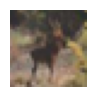

In [14]:
_ = random.randint(0,len(data_train))
print(f"For picture #{_} - {label_train[_]} ({superclass_dict[label_train[_]]}):")
fig = plt.figure(figsize=(1,1))
fig.add_subplot(1,1,1)
plt.imshow(data_train[_])
plt.axis("off")
plt.show()

Трохи більше картинок з тренувальної та тестувальної вибірок...

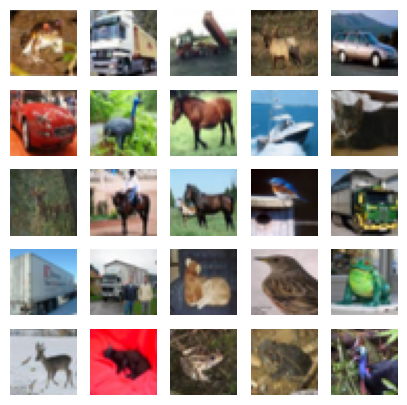

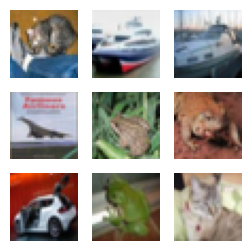

In [15]:
def show_pictures_n_m(data,n,m:int):
    fig = plt.figure(figsize=(max(n,m),max(n,m)))
    for _ in range (n*m):
        fig.add_subplot(n,m,_+1)
        plt.imshow(data[_])
        plt.axis("off")
    plt.show()

show_pictures_n_m(data_train,5,5)
show_pictures_n_m(data_test,3,3)

### Подальша підготовка даних для тренувань мережі

In [16]:
data_train.shape[0]

50000

In [17]:
BUFFER_SIZE = data_train.shape[0]
BATCH_SIZE = 256
# як альтернатива
# BATCH_SIZE = int(BUFFER_SIZE / 100)

In [18]:
def prepare_images(data_set, buffer_size, batch_size):
  prepared_images = data_set.astype("float32")
  prepared_images = (prepared_images - 127.5) / 127.5
  prepared_images = prepared_images[:1000]
  # prepared_images = tf.data.Dataset.from_tensor_slices(prepared_images)
  # #Перемішаємо дані випадковим чином
  # prepared_images = prepared_images.shuffle(buffer_size=buffer_size).batch(batch_size=batch_size)
  return prepared_images

In [19]:
train_images = prepare_images(data_train, BUFFER_SIZE, BATCH_SIZE)

In [20]:
train_images.shape

(1000, 32, 32, 3)

In [21]:
len(train_images)

1000

In [22]:
BUFFER_SIZE = train_images.shape[0]
BATCH_SIZE = int(BUFFER_SIZE / 100)

# Створення та тренування генератора і дискримінатора

Генератор - використовує шари `tf.keras.layers.Conv2DTranspose` (для підвищення дискретності),щоб створювати зображення з вихідного випадкового шуму (random noise). Починається шаром `Dense`, який приймає це початкове значення, а потім кілька разів підвищує дискретизацію, поки не досягне бажаного розміру зображення.

Дискримінатор - Це класифікатор зображень на основі CNN.

Він класифікує (визначає) якою є згенерована картинка - справжньою чи фейковою. Модель тренується показувати позитивне значення для справжньої картинки і негативне для фейкової.

In [23]:
def real_or_fake(decision):
  if decision>=0:
    return "Real"
  else:
    return "Fake"

## Змінні

In [24]:
# Швидкість навчання
LEARNING_RATE = 2e-4
# Вхідна розмірність
INPUT_DIM = 100

## Функції створення генератора та дискримінатора

In [25]:
def build_generator(nodes=4, input_dim=100, alpha = 0.2):
  """Створення генератора"""
  model = tf.keras.Sequential()
  # Основа для зображення 4 * 4 * 256
  n_f_nodes = 256 * nodes * nodes
  model.add(layers.Dense(n_f_nodes, input_dim = input_dim))
  # model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha = alpha))
  model.add(layers.Reshape((nodes, nodes, 256)))
  # Підвищення дискретизації до 8x8
  model.add(layers.Conv2DTranspose(128, (nodes, nodes), strides=(2, 2), padding='same'))
  # model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha = alpha))
  # Підвищення дискретизації до 16x16
  model.add(layers.Conv2DTranspose(128, (nodes, nodes), strides=(2, 2), padding='same'))
  # model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha = alpha))
  # Підвищення дискретизації до 16x16
  model.add(layers.Conv2DTranspose(128, (nodes, nodes), strides=(2, 2), padding='same'))
  # model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha = alpha))
  # Вихідний шар
  model.add(layers.Conv2D(3, (3, 3), activation='tanh', padding='same'))

  print("Створено Генератор")
  return model

In [26]:
def build_discriminator(input_shape = (32,32,3), alpha = 0.2):
  """Створення дискримінатора"""
  model = tf.keras.Sequential()
  # Перший шар
  model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=input_shape))
  model.add(layers.LeakyReLU(alpha=alpha))
  model.add(layers.Dropout(0.3))
  # 3меншення дискретизації
  model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  # model.add(layers.Dropout(0.3))
  # 3меншення дискретизації
  model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU(alpha=alpha))
  model.add(layers.Dropout(0.3))
  # Класифікатор
  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))

  print("Створено Дискримінатор")
  return model

In [27]:
def build_gen_disc_model(gen_model, disc_model):
  '''
  Комбінована модель генератора і дискримінатора,
  для оновлення генератора
  '''
  # зробимо ваги для дискримінатора нетренованими
  disc_model.trainable = False
  # З'єднаємо дві моделі
  model = tf.keras.Sequential()
  # Додамо генератор
  model.add(gen_model)
  # Додамо дискримінатор
  model.add(disc_model)

  print("Створено Генератор-Дискримінатор")
  return model

In [28]:
def compile_model(model, opt, loss, metrics):
  '''Компіляція створеної моделі'''
  model.compile(loss = loss, optimizer = opt, metrics = metrics)
  print("Модель скомпільовано")

## Функції роботи генератора

In [29]:
def generate_real_images(dataset, n_images):
  '''Генерація реальних зображень'''
  # Виберемо випадкове зображення
  idx = np.random.randint(0, dataset.shape[0], n_images)
  # print(f"Func = g_r_i, idx = {idx}")
  # print(f"Func = g_r_i, idx.shape = {idx.shape}")
  # Отримаємо вибрані зображення
  X = dataset[idx]
  # print(f"Func = g_r_i, X = {X}")
  # print(f"Func = g_r_i, X.shape = {X.shape}")
  # Згенеруємо 'справжні' мітки класу - одинична матриця
  y = np.ones((n_images, 1))
  # print(f"Func = g_r_i, y = {y}")
  # print(f"Func = g_r_i, y.shape = {y.shape}")
  return X, y

In [30]:
def generate_points(input_dim, n_images):
  '''
  Генерація точок в прихованому вхідному шарі просторі
  як вхідні дані для генератора
  '''
  # Генерація точок
  x_input = np.random.randn(input_dim * n_images)
  # print(f"Func = g_p, x_input.shape = {x_input.shape}")
  # Зміна форми до форми пакету виходів мережі
  x_input = x_input.reshape(n_images, input_dim)
  # print(f"Func = g_p, x_input.reshape = {x_input.shape}")
  return x_input

In [31]:
def generate_fake_images(gen_model, input_dim, n_images):
  '''Генерація фейкових зображень'''
  # Генеруємо точки для вхідного шару
  x_input = generate_points(input_dim, n_images)
  # print(f"Func = g_f_i, x_input.shape = {x_input.shape}")
  # Генерація (передбачення) генератором
  X = gen_model.predict(x_input, verbose = 0)
  # print(f"Func = g_f_i, X_input.shape = {X.shape}")
  # Створення 'фейкового зображення' - матриця нулів
  y = np.zeros((n_images, 1))
  # print(f"Func = g_f_i, y.shape = {y.shape})")
  return X, y


## Функції обробки результатів роботи моделей

In [32]:
def show_save_plot(examples, epoch, to_save, n=5):
  '''
  Створення, вивіт та за необхідності збереження зображень
  '''
  # Масштабування виводу зображення (від [-1,1] до [0,1])
  examples = (examples + 1) / 2.0
  # Малювання зображень
  for i in range(n * n):
      plt.subplot(n, n, 1 + i)
      # Приберемо виведення осей
      plt.axis('off')
      # Вивід зображення
      plt.imshow(examples[i])
  # Збереження зображення за необхідності
  if to_save:
    filename = 'gen_img_e%03d.png' % (epoch+1)
    plt.savefig(filename)
  plt.show()

In [33]:
def summary_performance(epoch, gen_model, disc_model, dataset, input_dim, n_images=100, to_save = False):
  '''
  Ф-я оцінки дискримінатором, побудова зображень
  '''
  # Генерація реальних зображень
  # print("Func =s_p_i, Генерація реальних зображень")
  X_real, y_real = generate_real_images(dataset, n_images)
  # Оцінка дискримінатором згенерованих реальних зображень
  # print("Func =s_p_i, Оцінка дискримінатором згенерованих реальних зображень")
  _, accuracy_real = disc_model.evaluate(X_real, y_real, verbose=0)
  # Генерація фейкових зображень
  # print("Func =s_p_i, Генерація фейкових зображень")
  x_fake, y_fake = generate_fake_images(gen_model, input_dim, n_images)
  # Оцінка дискримінатором згенерованих фейкових зображень
  # print("Func =s_p_i, Оцінка дискримінатором згенерованих фейкових зображень")
  _, accuracy_fake = disc_model.evaluate(x_fake, y_fake, verbose=0)
  # Загальний вивід інформації роботи дискримінатора
  # print("Func =s_p_i, Загальний вивід інформації роботи дискримінатора")
  print(f"Точність для реального зображення: {accuracy_real*100 : .0f}\n\
Точність для фейкового зображення {accuracy_fake * 100:.0f}")
  show_save_plot(x_fake, epoch, to_save = False)

## Функція тренування генератора і дискримінатора

In [34]:
def train(gen_model, disc_model, gen_disc_model, dataset, input_dim, n_epochs, batch_size):
  '''Функція тренування генератора і дискримінатора'''
  from IPython import display
  import time as tm
  start = tm.time()
  # Кількість пакетів на епоху
  batch_per_epoch = int(dataset.shape[0] / batch_size)
  half_batch = int(batch_size / 2)
  # Ручний перелік епох
  for i in range(n_epochs):
    ep_start = tm.time()
    print(f"Епоха {i+1} з {n_epochs}")
    # Перелік пакетів у тренувальній вибірці
    for j in range(batch_per_epoch):
      # print(f"J {j+1} з {batch_per_epoch}")
      # Випадкова генерація 'реальних' зображень
      # print("Випадкова генерація 'реальних' зображень")
      X_real, y_real = generate_real_images(dataset, half_batch)
      # Оновлення вагів дискримінатора для 'реальних' зображень
      # print("Оновлення вагів дискримінатора для 'реальних' зображень")
      d_loss1, _ = disc_model.train_on_batch(X_real, y_real)
      # Генерація 'фейкових' зображень
      # print("Генерація 'фейкових' зображень")
      X_fake, y_fake = generate_fake_images(gen_model, input_dim, half_batch)
      # Оновлення вагів дискримінатора для 'фейкових' зображень
      # print("Оновлення вагів дискримінатора для 'фейкових' зображень")
      d_loss2, _ = disc_model.train_on_batch(X_fake, y_fake)
      # Підготовка точок у вхідному шарі як вхідних для генератора
      # print("Підготовка точок у вхідному шарі як вхідних для генератора")
      X_gen_disc = generate_points(input_dim, batch_size)
      # Створення інвертованих міток для фейкових зображень
      # print("Створення інвертованих міток для фейкових зображень")
      y_gen_disc = np.ones((batch_size, 1))
      # Оновлення генератора через значення помилок дискримінатора
      # print("Оновлення генератора через значення помилок дискримінатора")
      gen_disc_loss = gen_disc_model.train_on_batch(X_gen_disc, y_gen_disc)
      # Загальна втрата для цього пакету
      if j+1 % 100 == 0:
          print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i + 1, j + 1, batch_per_epoch, d_loss1, d_loss2, gen_disc_loss))
    # Проміжна оцінка продуктивності моделі
    if (i+1) % 1 == 0:
      summary_performance(i, gen_model, disc_model, dataset, input_dim, to_save=False)
    print(f"Час навчання епохи {i+1} - {(tm.time()-ep_start):.2f} сек")
  print(f"Загальний час навчання на {n_epochs} епохах - {(tm.time()-start):.2f} сек")

## Створення і налаштування генератора

In [35]:
LOSS = "binary_crossentropy"
OPT = Adam(learning_rate=LEARNING_RATE)
METRICS = []

generator = build_generator(nodes=4, input_dim=100, alpha = 0.2)
compile_model(generator, OPT, LOSS, METRICS)

generator.summary()

Створено Генератор
Модель скомпільовано
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              413696    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         524416    
 anspose)                                                        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 128)       262272    
 Transpose)     

2024-07-25 06:10:21.688852: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-25 06:10:21.689357: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Створення і налаштування дискримінатора

In [36]:
LOSS = "binary_crossentropy"
OPT = Adam(learning_rate=LEARNING_RATE)
METRICS = ["accuracy"]

discriminator = build_discriminator(input_shape = (32,32,3), alpha = 0.2)
compile_model(discriminator, OPT, LOSS, METRICS)

discriminator.summary()

Створено Дискримінатор
Модель скомпільовано
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        1792      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)         295168    
                                                                 
 leaky_re_

## Створення і налаштування загальної моделі генератор-дискримінатор

In [37]:
LOSS = "binary_crossentropy"
OPT = Adam(learning_rate=LEARNING_RATE)
METRICS = []

gen_disc = build_gen_disc_model(generator, discriminator)
compile_model(gen_disc, OPT, LOSS, METRICS)

gen_disc.summary()

Створено Генератор-Дискримінатор
Модель скомпільовано
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32, 32, 3)         1466115   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 374913    
                                                                 
Total params: 1841028 (7.02 MB)
Trainable params: 1466115 (5.59 MB)
Non-trainable params: 374913 (1.43 MB)
_________________________________________________________________


generated_image.shape = (1, 32, 32, 3)
Точність decision = 0.5003294944763184
Зображення - Real


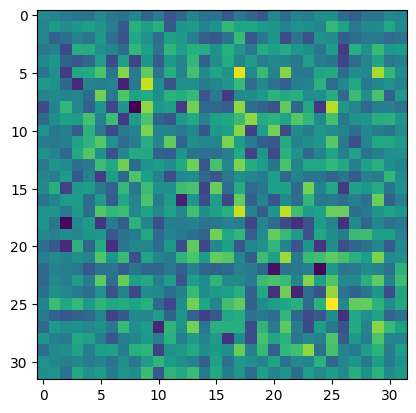

In [38]:
# Генерування зображення та його класифікація дискримінатором без навчання
noise = tf.random.normal([1, INPUT_DIM])
generated_image = generator(noise, training = False)
decision = discriminator(generated_image).numpy()[0][0]
print(f"generated_image.shape = {generated_image.shape}") #TensorShape([1, 32, 32, 3])
print(f"Точність decision = {decision}")
verdict = real_or_fake(decision)
print(f"Зображення - {verdict}")
plt.imshow(generated_image[generated_image.shape[0]-1, :,: ,0])
plt.show()

## Тренування моделей

Задаємо тренувальні параметри

In [39]:
EPOCHS = 1

In [40]:
train_images.shape

(1000, 32, 32, 3)

In [41]:
type(train_images)

numpy.ndarray

Епоха 1 з 1
Точність для реального зображення:  91
Точність для фейкового зображення 100


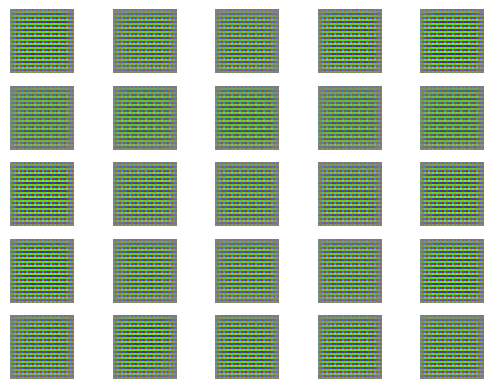

Час навчання епохи 1 - 13.55 сек
Загальний час навчання на 1 епохах - 13.55 сек


In [42]:
train(gen_model = generator,
      disc_model = discriminator,
      gen_disc_model = gen_disc,
      dataset = train_images,
      input_dim = INPUT_DIM,
      n_epochs = EPOCHS,
      batch_size = BATCH_SIZE)

In [43]:
generator.save("generator.h5")

/home/vasily/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [44]:
discriminator.save("discriminator.h5")